In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np
import tensorflow as tf


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [2]:
remove = ()

data_train = fetch_20newsgroups(subset='train',
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test',
                               shuffle=True, random_state=42,
                               remove=remove)


In [3]:
target_names = data_train.target_names
y_train, y_test = data_train.target, data_test.target

In [4]:
print("Extracting features from the training data using a sparse vectorizer")
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)

print("n_samples: %d, n_features: %d" % X_train.shape)

Extracting features from the training data using a sparse vectorizer
n_samples: 11314, n_features: 129791


In [5]:

print("Extracting features from the test data using the same vectorizer")
X_test = vectorizer.transform(data_test.data)
print("n_samples: %d, n_features: %d" % X_test.shape)

Extracting features from the test data using the same vectorizer
n_samples: 7532, n_features: 129791


In [6]:
X_train = X_train.toarray()
X_test = X_test.toarray()

#print(str(X_train))
print("feature size train: " + str(X_train[0].size))
print("feature size test: " + str(X_test[0].size))

print("number of classes: " + str(len(target_names)))

feature size train: 129791
feature size test: 129791
number of classes: 20


In [7]:
# Specify that all features have real-value data
feature_columns = [tf.feature_column.numeric_column("x", shape=[X_train[0].size])]


In [8]:
# Build 3 layer DNN with 10, 20, 10 units respectively.
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                        hidden_units=[50, 500, 50],
                                        n_classes=len(target_names))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': '/var/folders/hb/6zr7m8351_9c0z1r1nljgnbh0000gn/T/tmpEdxRcX', '_save_summary_steps': 100}


In [9]:
# Define the training inputs
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": np.array(X_train)},
      y=np.array(y_train),
      num_epochs=None,
      shuffle=True)


In [10]:
# Train model.
classifier.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/hb/6zr7m8351_9c0z1r1nljgnbh0000gn/T/tmpEdxRcX/model.ckpt.
INFO:tensorflow:loss = 383.451, step = 1
INFO:tensorflow:global_step/sec: 1.70731
INFO:tensorflow:loss = 235.596, step = 101 (58.592 sec)
INFO:tensorflow:global_step/sec: 1.80058
INFO:tensorflow:loss = 38.9572, step = 201 (55.530 sec)
INFO:tensorflow:global_step/sec: 1.92933
INFO:tensorflow:loss = 4.2419, step = 301 (51.836 sec)
INFO:tensorflow:global_step/sec: 1.84869
INFO:tensorflow:loss = 1.53112, step = 401 (54.088 sec)
INFO:tensorflow:global_step/sec: 1.87376
INFO:tensorflow:loss = 0.404476, step = 501 (53.373 sec)
INFO:tensorflow:global_step/sec: 1.76272
INFO:tensorflow:loss = 0.26693, step = 601 (56.729 sec)
INFO:tensorflow:global_step/sec: 1.82728
INFO:tensorflow:loss = 0.199196, step = 701 (54.721 sec)
INFO:tensorflow:global_step/sec: 1.90321
INFO:tensorflow:loss = 2.33807, step = 801 (52.544 sec)
INFO:tensorflow:globa

In [11]:
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": np.array(X_test)},
      y=np.array(y_test),
      num_epochs=1,
      shuffle=False)

In [12]:
predictions = list(classifier.predict(input_fn=test_input_fn))
predicted_classes = [p["classes"] for p in predictions]

predicted_classes = np.array(predicted_classes, dtype=np.int32).flatten()

INFO:tensorflow:Restoring parameters from /var/folders/hb/6zr7m8351_9c0z1r1nljgnbh0000gn/T/tmpEdxRcX/model.ckpt-2000


In [13]:
score = metrics.accuracy_score(y_test, predicted_classes)
print(score)
print("accuracy:  %%%0.1f" % (score * 100))

0.706054168879
accuracy:  %70.6


In [14]:
print(predicted_classes)

[ 4 12  0 ..., 18 12 15]


In [15]:
y_testl = []

for a in y_test:
    y_testl.append(data_train.target_names[a])

In [16]:
predicted_classesl = []

for a in predicted_classes:
    predicted_classesl.append(data_train.target_names[a])

In [17]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
cnf_matrix = confusion_matrix(y_testl, predicted_classesl, labels=data_train.target_names)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[188   0   2   0   0   6   1   0   0   1   3   1   1   4   2  10   0   2
   34  64]
 [  0 251  13  14  11  27   1   0   0  11   0   2  38   3   0   0   0   0
   17   1]
 [  0  26 208  21   2  13   3   0   0   7   7   0  80   0   1   0   0   0
   26   0]
 [  0  17  11 241   6   0  11   0   0   4   0   0  98   1   0   0   1   0
    2   0]
 [  0  27   0  57 242   0   4   3   0  26   0   0  21   2   0   0   3   0
    0   0]
 [  0  46  44   1   1 262   0   0   0   4   0   0  17   1   0   0   0   0
   19   0]
 [  0   1   2  32   6   0 283  24   0   3   4   0  25   6   0   0   1   0
    3   0]
 [  0   1   0  34   4   0  34 299   2   0   0   0   4   5   0   0  12   0
    1   0]
 [  0   1   0   1  11   0   1  15 337   3   1   0   1   2   1   0  24   0
    0   0]
 [  0   5   0   0   2   0   4   1   0 328   1   0  12  10   0   0   2   0
   32   0]
 [  0   0   2   0   0   0  11   1   0   4 340   1  14  12   0   0   0   0
   14   0]
 [  0   0   1   0   1   0

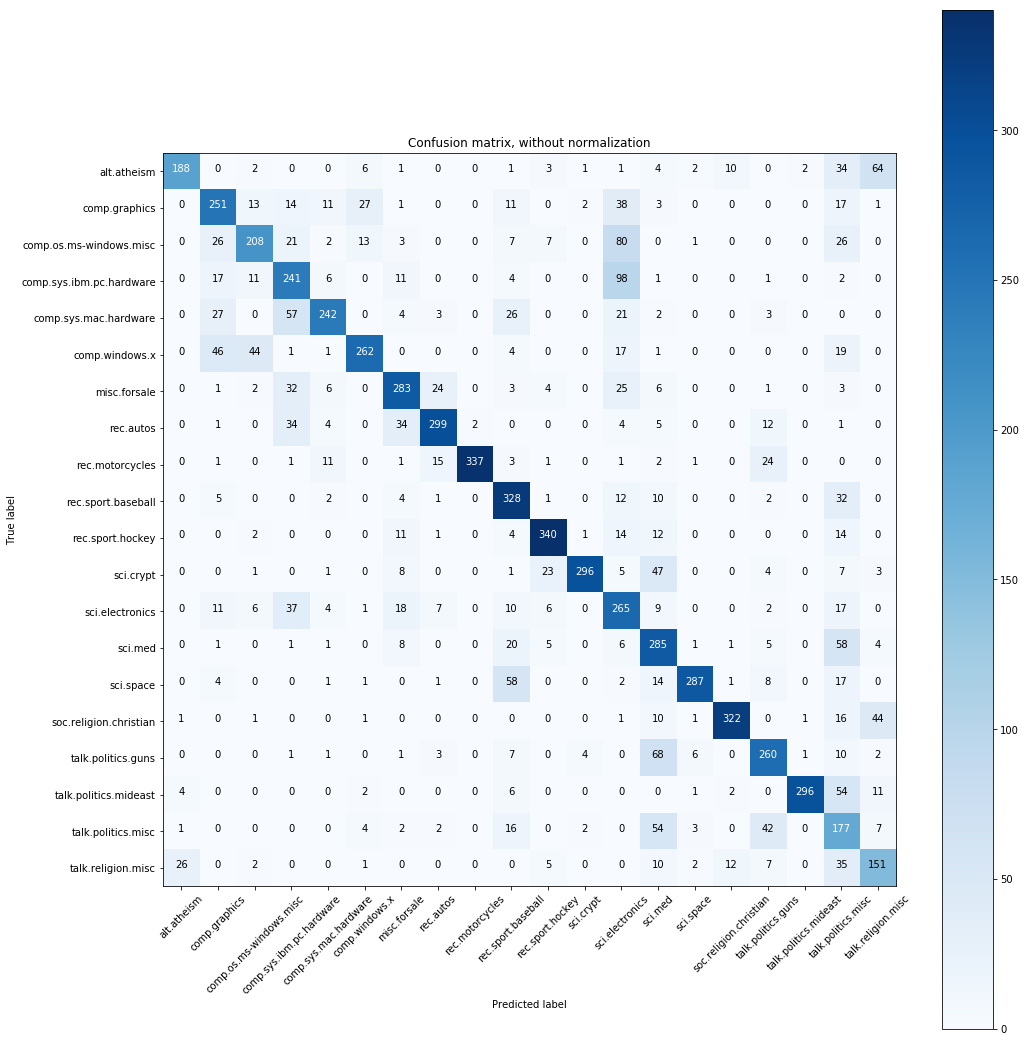

In [24]:
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=data_train.target_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [22]:
plt.savefig('books_read.png')

In [25]:
score*len(y_test)

5318.0

In [26]:
(1-score)*len(y_test)

2214.0